# A share BAB factor

## Setting and package loading

In [316]:
import pandas as pd
import os
import numpy as np
import datetime
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib as plt


In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## Data wrangling

In [ ]:
### Loading raw data

In [289]:
 raw=pd.read_pickle('Daily_return_with_cap(2).pkl')
raw['date']=raw['TRADE_DT']
raw.set_index(['TRADE_DT'])
factor=pd.read_pickle('CH3_Daily.pkl')







# df=raw[['S_INFO_WINDCODE','adj_pct_chg','TRADE_DT']]
# df['month']=df['TRADE_DT'].dt.to_period('M')
# df1=df.groupby([df['S_INFO_WINDCODE'],df['month']]).sum()
# df3=df1.pivot_table(index='month', values='adj_pct_chg', columns='S_INFO_WINDCODE').stack(dropna=False).reset_index()
# df3.columns=['date','id','ret']

### Market portfolio return 

In [290]:
### mktrf = market return- riskfree
mkt=factor[['mktrf','TRADE_DT']]
mkt_monthly=mkt.set_index(['TRADE_DT']).resample('M').sum()
mkt_monthly=mkt_monthly.reset_index()
mkt_monthly['date']=mkt_monthly['TRADE_DT'].dt.to_period('M')
mkt_monthly=mkt_monthly[['mktrf','date']]
mkt_monthly.head()

,mktrf,date
0,0.093986,1991-12
1,0.052389,1992-01
2,0.152576,1992-02
3,0.082954,1992-03
4,0.232935,1992-04
5,0.305600,1992-05
6,-0.111833,1992-06
7,0.071370,1992-07
8,-0.133992,1992-08
9,-0.038533,1992-09


### Market riskfree return 

In [293]:
mkt_rf=factor[['rf','TRADE_DT']]
mktrf_monthly=mkt_rf.set_index(['TRADE_DT']).resample('M').sum()
mktrf_monthly=mktrf_monthly.reset_index()
mktrf_monthly['date']=mktrf_monthly['TRADE_DT'].dt.to_period('M')
mktrf_monthly=mktrf_monthly[['date','rf']]
mktrf_monthly.head()

,date,rf
0,1991-12,0.0044
1,1992-01,0.0044
2,1992-02,0.0034
3,1992-03,0.0044
4,1992-04,0.0044


### Stock monthly return

In [295]:
df=raw[['S_INFO_WINDCODE','adj_pct_chg','TRADE_DT']]
df['month']=df['TRADE_DT'].dt.to_period('M')
df=df.groupby([df['S_INFO_WINDCODE'],df['month']]).sum()
df=df.pivot_table(index='month', values='adj_pct_chg', columns='S_INFO_WINDCODE').stack(dropna=False).reset_index()
df.columns=['date','id','ret']
df.head()

,date,id,ret
0,1990-12,000001.SZ,NaN
1,1990-12,000002.SZ,NaN
2,1990-12,000003.SZ,NaN
3,1990-12,000004.SZ,NaN
4,1990-12,000005.SZ,0.0


## Calculate market std_est

In [299]:
#calculate rolling standard deviation
# shift below is used to use PREVIOUS 12 month
mkt_monthly['std_est'] = mkt_monthly['mktrf'].rolling(12).std().shift(1)
#Without shifting we get the REALIZED 12 month rolling std (though we will not use it)
mkt_monthly['std_real'] = mkt_monthly['mktrf'].rolling(12).std()

### Merge all the data

In [300]:
DF = pd.merge(df, mkt_monthly, on='date')
DF = pd.merge(DF, mktrf_monthly, on='date')
DF.head()

,date,id,ret,mktrf,std_est,std_real,rf
0,1991-12,000001.SZ,0.058117,0.093986,NaN,NaN,0.0044
1,1991-12,000002.SZ,0.109160,0.093986,NaN,NaN,0.0044
2,1991-12,000003.SZ,0.070351,0.093986,NaN,NaN,0.0044
3,1991-12,000004.SZ,0.044180,0.093986,NaN,NaN,0.0044
4,1991-12,000005.SZ,0.041134,0.093986,NaN,NaN,0.0044


## Calculate stock std_est and corr_est

In [302]:
# define function to estimate rolling 5 year(60 month) correlations with minimum 36 non-missing datapoints
def roll_corr(x):
    return pd.DataFrame(x['ret'].rolling(60, min_periods=36).corr(x['mktrf']))


#same for rolling std, but with 1 year horizon
def roll_var(x):
    return pd.DataFrame(x['ret'].rolling(12, min_periods=12).std())

In [303]:
DF['corr_est'] = DF.groupby('id')[['ret', 'mktrf']].apply(roll_corr)

DF['corr_est'] = DF.groupby('id')['corr_est'].shift(1
                                                    
DF['id_var_est'] = DF.groupby('id')[['ret', 'mktrf']].apply(roll_var)
                                                    
DF['id_var_est'] = DF.groupby('id')[['id_var_est']].shift(1)

## Calculate beta_est

In [306]:
#drop all the rows where in ANY column there is a NAN value
DF = DF.dropna(how='any')

# Estimation betas like on page 8 in eq (14) in the paper
DF['beta_est'] = DF['corr_est']*DF['id_var_est'].div(DF['std_est'])

#Shrink the betas to make them less noisy eq(15)
DF['beta_est'] = 0.6*DF['beta_est'] + 0.4


/Users/albert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/albert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [307]:
# Then we divide stocks into ten portfolios based on the their beta_est quantile
DF['q'] = DF.groupby('date')['beta_est'].apply(lambda x: pd.qcut(x, 10, labels=range(1, 11)))



/Users/albert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Get ten portfolios monthly return

In [312]:
# check the average mean excess return and average estimated beta and compare it with the table 3
print(DF.groupby('q')[['beta_est', 'ret']].mean())
alpha = DF.groupby(['date', 'q'])[['ret', 'mktrf']].mean().reset_index()
alpha.columns = ['date', 'q', 'ret', 'mktrf']
alpha.head()
result=DF.groupby('q')[['beta_est', 'ret']].mean()

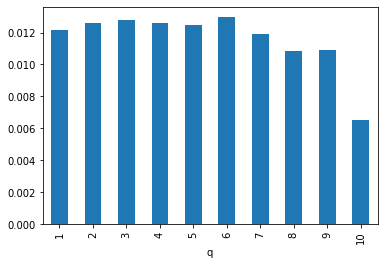

In [327]:
result['ret'].plot(kind='bar')
# plt.show()

In [328]:
#Create an empty dataframe to store estimated alphas and betas
par = pd.DataFrame()
for i in range(1,11):
    # pick the portfolio
    alpha0 = alpha[alpha['q']==i]
    x = alpha0['mktrf'].copy()
    # add a constant to the model, default ols goes without it
    x = sm.add_constant(x)
    
    #estimate the model
    results = sm.OLS(alpha0['ret'], x).fit(cov_type='HC1')
    #print the table with estimates
    
    print(results.summary())
    # get alphas and betas
    par0 = results.params
    # give a name to the row of parameters, we need to know for which portfolio we got the estimates
    par0.name= 'port_{}'.format(i)
    # join it with the dataframe of params
    par = par.append(par0)
par.columns = ['alpha', 'beta_realised']
print(par)

/Users/albert/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     604.3
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           7.40e-74
Time:                        17:11:01   Log-Likelihood:                 563.88
No. Observations:                 302   AIC:                            -1124.
Df Residuals:                     300   BIC:                            -1116.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.002      3.376      0.0

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     921.0
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.93e-93
Time:                        17:11:01   Log-Likelihood:                 517.67
No. Observations:                 302   AIC:                            -1031.
Df Residuals:                     300   BIC:                            -1024.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.090      0.9